# Temperature Salinity Plots

In this notebook there are a few examples on how to plot temperature-salinity diagrams of model output. The cosima cookbook is used to extract data, however there are other methods including using dask to get variables that could also be used, that are contained (but are outdated) in previous versions of this notebook.

The first method uses `pandas` dataframe to plot the data with datashader, and then the second method uses pandas dataframe to add a colourmap from the age variable. The advantage of this method is that it is efficient, but the datashader module is not as simple and user friendly as `matplotlib`.

The third method uses xarray scatter plots to plot a T-S diagram without pandas, instead with the xarray DataArray object. Its limitation is that it is slow. 

The fourth method uses `xhistogram` to bin the data so that the number of points at one T-S value is clearer.

The fifth method is a documented example which uses the DataArray to make a 2D scipy histogram so that a true volume weighted T-S plot can be constructed, which takes ito account the differing sizes of cells in the model. The density isopycnals are also included in here too because they are often useful for these types of plots.

Firstly, we load our modules as required.

In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc
import bokeh.plotting as bp

import matplotlib.pyplot as plt
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
import gsw
import scipy as scipy
from scipy import stats
from xhistogram.xarray import histogram

import holoviews as hv
import holoviews.operation.datashader as hd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


<Client: 'tcp://127.0.0.1:43149' processes=8 threads=48, memory=202.49 GB>

The usual `cosima-cookbook` loading of variables...

In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
expt = '01deg_jra55v13_ryf9091'

We load only one year of daily data and for a small portion of the ocean. If one loads the global ocean dataset the computations take very very very long.

(Have a look at the discussion in https://github.com/COSIMA/cosima-recipes/pull/75)

In [5]:
start_time, end_time = '2059-01-01', '2060-01-01'
temp = cc.querying.getvar(expt, 'temp', session, 'ocean.nc', 
                          start_time=start_time, end_time=end_time).sel({'time': slice(start_time, end_time), 'xt_ocean': slice(-195, -175), 'yt_ocean': slice(-78, -68)})
salt = cc.querying.getvar(expt, 'salt', session, 'ocean.nc', 
                          start_time=start_time, end_time=end_time).sel({'time': slice(start_time, end_time), 'xt_ocean': slice(-195, -175), 'yt_ocean': slice(-78, -68)})

## Plotting T-S diagrams with pandas and dask dataframe

We first construct the dataframe in pandas of the temperature and salinity data points. The dataframe matches temperature and salinity values from the input data which has been reshaped into a one dimensional array, and places them in the dataframe.

In [6]:
t_blocks = [x.reshape((-1, )) for x in temp.data.to_delayed().reshape((-1, ))]
s_blocks = [x.reshape((-1, )) for x in salt.data.to_delayed().reshape((-1, ))]
dfs = [delayed(pd.DataFrame)({'temp': t, 'salt': s}, copy=False) for t, s in zip(t_blocks, s_blocks)]

Using `dask.dataframe` to lazily read the files...

In [7]:
df = dd.from_delayed(dfs)

And then we use datashader to plot the T-S diagram. The colour mapping relates to how many points have that T-S coordinate, with darkblue being used to indicate a greater number of datapoints at that datapoint.

In [8]:
cvs = ds.Canvas(plot_width=400, plot_height=400)#, x_range =(31, 36), y_range=(-2, 3))
agg = cvs.points(df, 'salt', 'temp')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='log')

And now, display a T-S plot of the global ocean.

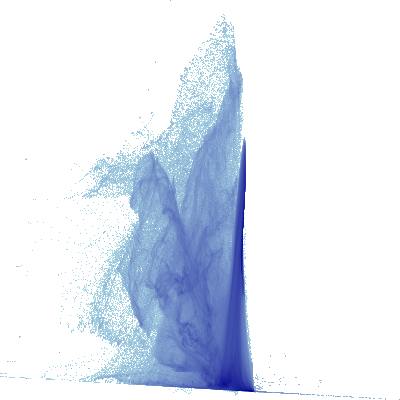

In [9]:
display(img)

As shown above, datashader creates a very detailed image of the T-S plot in a relatively small amount of time by using `dask`. Datashader is also efficient for large datasets because it plots an accurate distribution of the datapoints given the size of your image, rather than plotting every datapoint as a simpler module like `matplotlib` does.

The above image is simply an image, but we can explort it into plotting software such as `bokeh` and `matplotlib` so that axes and labels can be added. Here we show the simplest T-S plot with datashader in each of these plotting programs, but more features could be added if you like.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
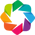

In [10]:
hd.shade.cmap=["lightblue", "darkblue"]
hv.extension("bokeh", "matplotlib") 

:RGB   [salt,temp]   (R,G,B,A)
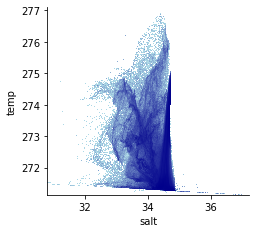

In [11]:
hv.output(backend="matplotlib")
# agg = ds.Canvas().points(df, 'x', 'y')
hd.shade(hv.Image(agg))

In [12]:
hv.output(backend="bokeh")
hd.shade(hv.Image(agg))

:RGB   [salt,temp]   (R,G,B,A)

## Forming a pandas dataframe and plotting with a third variable

In the first example we simply calculated the T-S distribution and coloured it by the number of objects at that coordinate. In this example, we colour data points with a third variable, so each cell has a salinity, temperature and age parameter. 

Once again we load our variables, this time for a smaller section (the Ross Sea).

In [13]:
start_time, end_time = '2059-01-01', '2060-01-01'

temp = cc.querying.getvar(expt, 'temp', session, 'ocean.nc', 
                          start_time=start_time, end_time=end_time).sel({'time': slice(start_time, end_time), 'xt_ocean': slice(-195, -175), 'yt_ocean': slice(-78, -68)})
salt = cc.querying.getvar(expt, 'salt', session, 'ocean.nc', 
                          start_time=start_time, end_time=end_time).sel({'time': slice(start_time, end_time), 'xt_ocean': slice(-195, -175), 'yt_ocean': slice(-78, -68)})
age_global = cc.querying.getvar(expt, 'age_global', session, 'ocean.nc', 
                                start_time=start_time, end_time=end_time).sel({'time': slice(start_time, end_time), 'xt_ocean': slice(-195, -175), 'yt_ocean': slice(-78, -68)})


In [14]:
age_global

<xarray.DataArray 'age_global' (time: 12, st_ocean: 75, yt_ocean: 237, xt_ocean: 200)>
dask.array<getitem, shape=(12, 75, 237, 200), dtype=float32, chunksize=(1, 7, 226, 200), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 -77.98 -77.94 -77.9 ... -68.1 -68.06 -68.01
  * xt_ocean  (xt_ocean) float64 -194.9 -194.8 -194.7 ... -175.2 -175.1 -175.0
  * time      (time) object 2059-01-16 12:00:00 ... 2059-12-16 12:00:00
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_age_since_surface_contact

In [15]:
temp2 = temp.values.reshape(1,-1)[0] - 273.15 # convert to degrees C
salt2 = salt.values.reshape(1,-1)[0]
age_global2 = age_global.values.reshape(1,-1)[0]

Above we repeated the pandas construction of a DataFrame as performed earlier, but with a third variable `age_global` that will colour the datapoints in the T-S plot.

Now we plot the age coloured T-S plot. The time needed for the computation is short, showing the efficiency of the process.

In [16]:
# Default plot ranges:
y_range = (-2, 5) # temperature
x_range = (32, 36) # salinity

In [17]:
df = pd.DataFrame({'temp': temp2, 'salt' : salt2, 'age_global' : age_global2}, copy=False)

In [18]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.points(df, 'salt', 'temp', ds.mean('age_global'))
    return tf.shade(agg)

In [19]:
%%time
cvs = ds.Canvas(plot_width=500, plot_height=500, x_range=x_range, y_range=y_range)
agg2 = cvs.points(df, 'salt', 'temp')

CPU times: user 428 ms, sys: 76.5 ms, total: 505 ms
Wall time: 482 ms


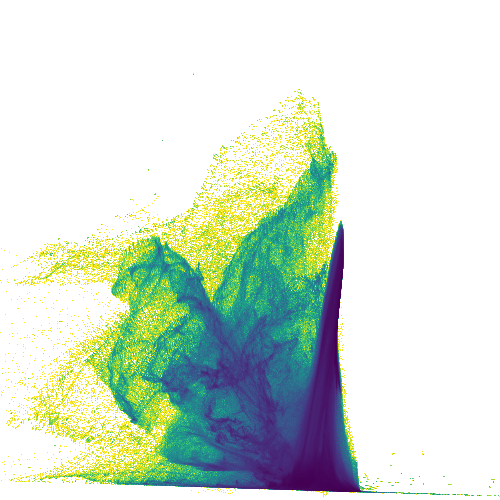

In [20]:
img = tf.shade(agg2, cmap=plt.cm.viridis_r)
img

In [21]:
hd.shade.cmap=plt.cm.viridis_r

hv.output(backend="bokeh")
hd.shade(hv.Image(agg2))

:RGB   [salt,temp]   (R,G,B,A)

As of early 2020, there is no easy way for datashader to implement a colourbar, which is unfortunate.

## `xarray`'s scatter plot method
Here we load the variables and combine them into a dataArray. We also upload the bathymetry and area of grid cells because we will use them in the 2D histogram in the next method.

Notice that the start_time and end_time varies between variables, because cosima cookbook is inconsistent in which times it extracts with the start_time and end_time. Double check your data by printing the arrays and seeing which times got extracted, and adjust as necessary to make sure all the arrays have the same start and end dates in the extracted data.

In [22]:
expt = '01deg_jra55v13_ryf9091'

variable = 'salt'
darray = cc.querying.getvar(expt, variable, session, ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable1 = 'temp'
darray1 = cc.querying.getvar(expt, variable1, session, ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable2 = 'pot_rho_2'
darray2 = cc.querying.getvar(expt, variable2, session, ncfile='ocean.nc', start_time='2059-03-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable3 = 'age_global'
darray3 = cc.querying.getvar(expt, variable3, session, ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable4= 'dzt' #depth of cell, varies in time 
darray4 = cc.querying.getvar(expt, variable4, session, ncfile='ocean.nc', start_time='2059-02-01', end_time='2059-12-31', chunks={'st_ocean':None})
variable5= 'area_t' #area of a cell
darray5 = cc.querying.getvar(expt, variable5, session, n=1)
variable6= 'ht' #bathymetry
darray6 = cc.querying.getvar(expt, variable6, session, n=1)

combined_array = xr.merge([darray, darray1, darray2, darray3, darray4, darray5, darray6])

The data array `combined_array` includes the whole ocean so we crop out a region, in this case in the Ross Sea.

In [23]:
section = combined_array.sel({'xt_ocean': slice(-195, -175), 'yt_ocean': slice(-78, -68)})

Now use `xr.plot.scatter` to make T-S diagram, with the `age_global` variable as a colour. It is a computationally expensive process, and the data for just one time is shown below (commented out in case you don't want to compute it).

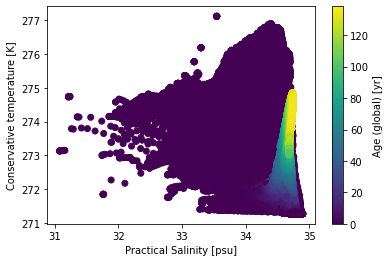

In [24]:
xr.plot.scatter(section.isel(time=0), 'salt', 'temp', hue='age_global');

## 2D histogram with `xhistogram`

We can also use the `xhistogram` package to bin the temperature salinity data into a 2D histogram. The process simply involves defining an array of values for each of the bins, and then using the histogram function to count the number of datapoints that fit in each 2D bin. 


In [25]:
sbins = np.arange(31, 38, 0.025)
tbins = np.arange(-2, 5, 0.1)

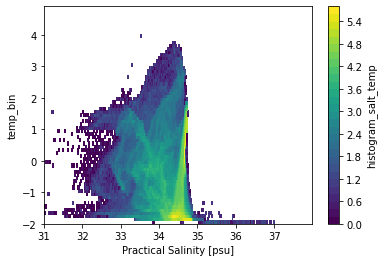

In [26]:
hTS = histogram(section.salt, section.temp - 273.15, bins=[sbins, tbins])
np.log10(hTS.T).plot(levels=31);

The plot above is coloured by the logarithm of number of cells that fit a particular T-S value. Unfortunately, this package is very slow if different volumes are used for the bins, but this can be specified with the argument 'weights = weightarray' where weightarray is an arraylike structure containing the weightings (or volume) of the cells. If the weight is constant, then you can also input a float into weights.

Below we do calculate the volume weighted xhistogram plot, by extracting the volume from the area and the cell width, both from the cosima cookbook as imported above. You may need to use a large number of cores on gadi for it to run.

In [27]:
Volume = section.dzt*section.area_t #broadcasting,
Volume = Volume.fillna(0) # convert NaN values to zeros as weighted average does not consider NaN values

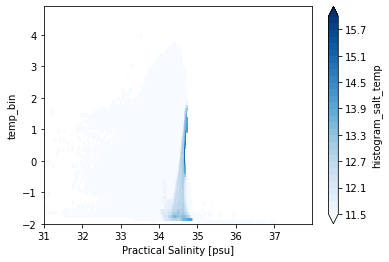

In [28]:
hTSw = histogram(section.salt, section.temp - 273.15, bins=[sbins, tbins], weights=Volume)
np.log10(hTSw.T).plot(levels=31, vmin=11.5, vmax=16, cmap='Blues', extend='both');

## Volume weighted T-S diagram (2D histogram using scipy)

Here is a T-S diagram where the colour of a pixel is determined by the volume of the cell. This helps account for varying sizes of cells and also allows you to calculate volumes of regions in T-S diagrams, for example to calculate the volume of a watermass with T-S characteristics.
There is also a method of calculating the freezing point and isopycnals which uses the Gibbs SeaWater (GSW) Oceanographic Toolbox. When we do this we also change the $x$-axis to absolute rather than practical salinity.

First we add some variables of volume and the $x,y,z$ coordinates as variables to the dataArray, because the dataArray had issues being input into `scipy` when $x,y,z$ were coordinates rather than variables.

In [29]:
section = section.assign(volume = lambda section : section.dzt * section.area_t)
section = section.assign(x = lambda section : 0*section.salt + section.xt_ocean)
section = section.assign(y = lambda section : 0*section.salt + section.yt_ocean)
section = section.assign(z = lambda section : 0*section.salt + section.st_ocean)

Now we define the pressure and absolute salinity as dataArrays.

In [30]:
trough = section

da_pressure = xr.DataArray(gsw.p_from_z(-trough.z, trough.y), dims=['time', 'st_ocean','yt_ocean','xt_ocean'],
                           coords={'time': trough.time,
                                   'st_ocean': trough.st_ocean,
                                   'yt_ocean': trough.yt_ocean,
                                   'xt_ocean': trough.xt_ocean})

da_saltabs = xr.DataArray(gsw.SA_from_SP(trough.salt, da_pressure, trough.x, trough.y), dims=['time', 'st_ocean','yt_ocean','xt_ocean'],
                           coords={'time': trough.time,
                                   'st_ocean': trough.st_ocean,
                                   'yt_ocean': trough.yt_ocean,
                                   'xt_ocean': trough.xt_ocean})

We reshape the dataArrays into lists, noting that due to the same shape of these arrays (see above note about start_time and end_time checking) the nth member of the list will correspond to the nth member of another list.

In [31]:
x = trough.isel(time=0).temp.values.reshape(1, -1)
x = x[~np.isnan(x)] - 273.15 # list of conservative temperatures of data points in degC

y = trough.isel(time= 0).volume.values.reshape(1, -1)
y = y[~np.isnan(y)]

z = da_saltabs.isel(time=0).values.reshape(1, -1)
z = z[~np.isnan(z)]

Here we use `stat.binned_statistic_2d` to bin the T-S data into bins. There are some extra parameters you can feed it but here we just set the number of bins in each axis to be 500, which will evenly space the bin edges from the minimum and maximum values of the data. We use bin statistic sum to add up the volume in each T-S bin.
Then by constructing a meshgrid and plotting the mesh, coloured by the value in the bin we output a 2D histogram. The isopycnals and freezing line are also added.

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'interpolation'
  app.launch_new_instance()


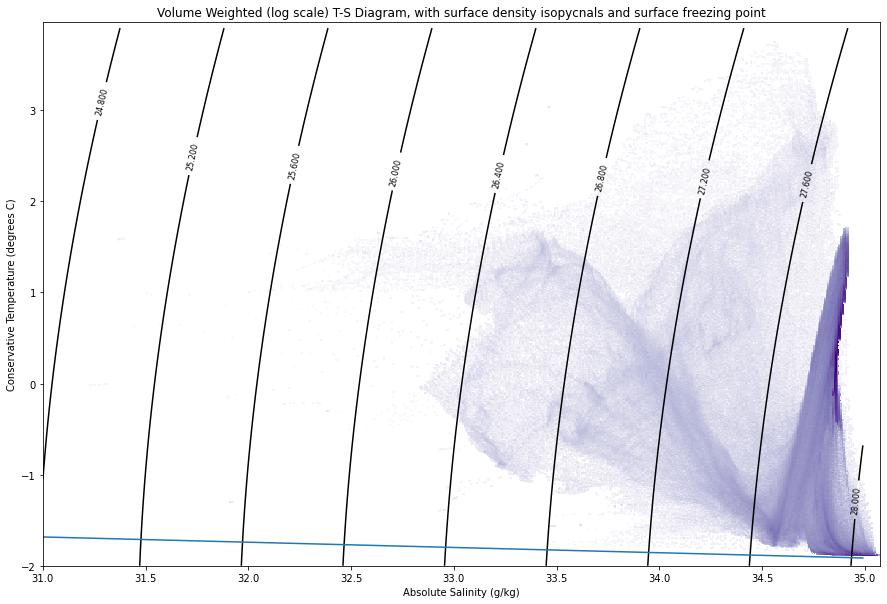

In [32]:
values, x_edges, y_edges, binnumber = stats.binned_statistic_2d(z, x, y, statistic = 'sum', bins = [500, 500]) 
# increase resolution by increasing number of bins
XX, YY = np.meshgrid(y_edges,x_edges) # creating a meshgrid structure from the bin edges so that it can be plotted

plt.figure(figsize=(15, 10))
plt.title('Volume Weighted (log scale) T-S Diagram, with surface density isopycnals and surface freezing point')

plt.pcolormesh(YY,XX,np.log(values),cmap='Purples') # log is used because in this data at least, a large amount of 
                                                    # volume is concentrated in a couple of T-S bins so we can't see the rest.

temp = np.arange(-2, 4, .1) # creating arrays for plotting the isopycnal and freezing point contours
salt = np.arange(31, 35, .01)
plt.plot(salt, gsw.CT_freezing(salt, 10.1325, 0)) # freezing point contour, pressure = 10.1325 dbar and saturation_fraction=0 - you can modify the 
temp_mesh,salt_mesh = np.meshgrid(temp, salt)
density = gsw.density.sigma0(salt_mesh, temp_mesh) # using surface density pot_rho_0
contours = plt.contour(salt_mesh, temp_mesh, density, 10, colors='k', interpolation='none')
plt.clabel(contours, inline=True, fontsize=8)

plt.xlabel('Absolute Salinity (g/kg)')
plt.ylabel('Conservative Temperature (degrees C)');